In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from tqdm.notebook import tqdm
import copy

import pandas as pd
import xarray as xr

import torch.nn as nn
import torch.optim as optim
import random
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error


In [2]:
torch.cuda.is_available()

True

# Prepare data

In [3]:
df = pd.read_csv('data/consumption_per_group_mba_hour-all-en-0000-00-00.csv')
df_energy = df.query("PRICE_AREA=='NO5'").set_index(['START_TIME','CONSUMPTION_GROUP']).VOLUME_KWH.unstack()
df_energy.index = pd.to_datetime(df_energy.index, utc=True)
df_energy['Total'] = df_energy.sum(axis=1)
df_energy.index = pd.to_datetime(df_energy.index.strftime("%Y-%m-%d %H:%M:%S"))

In [4]:
df_weather = pd.read_csv('data/florida_weather_data.csv',delimiter=';', skipfooter=1, engine='python', na_values='-')
df_weather.index= pd.to_datetime(df_weather['Tid(norsk normaltid)'], dayfirst=True).rename('date')
df_weather = df_weather.iloc[:,3:].sort_index().astype(float)
df_weather.columns = ['Pr','Tmax','Tmin','v_mean','v_max']


In [5]:
df_total = pd.concat([df_weather, df_energy], axis=1).dropna()
df_total['hour'] = df_total.index.hour
df_total['dayofyear'] = df_total.index.dayofyear
df_total['month'] = df_total.index.month
df_total['dayofweek'] = df_total.index.dayofweek

<Axes: >

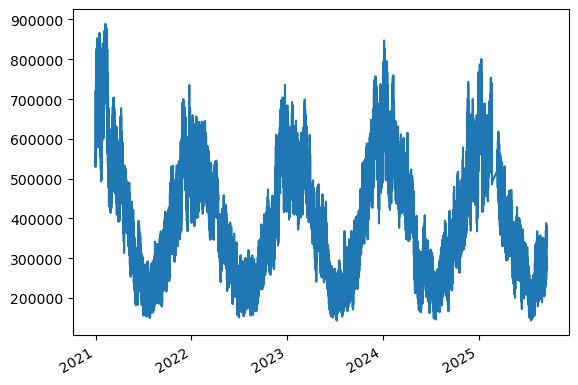

In [6]:
df_total['Household'].plot()

# Make predictions

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Prepare data

In [8]:
X = df_total[['Pr','Tmax','Tmin','v_mean','v_max','hour','month']].values
y = df_total.loc[:,['Household']].values

df_train, df_test = train_test_split(df_total, test_size=0.3, random_state=42, shuffle=True)

X_train = df_train[['Pr','Tmax','Tmin','v_mean','v_max','hour','month','dayofweek']].values
X_test = df_test[['Pr','Tmax','Tmin','v_mean','v_max','hour','month','dayofweek']].values
y_train = df_train.loc[:,['Household']].values
y_test = df_test.loc[:,['Household']].values

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


## Design model and choose hyperparameters

In [9]:
num_features = X_train.shape[1]
num_predictions = y_train.shape[1]
model = nn.Sequential(
    nn.Linear(num_features, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, num_predictions)
)

model = model.to(device) # Put the model on the GPU
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training parameters
n_epochs = 200   # number of epochs to run
batch_size = 128  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

## Train model

In [10]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss.detach()))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test).detach()
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
# restore model and return best accuracy
model.load_state_dict(best_weights)

  0%|          | 0/200 [00:00<?, ?it/s]

<All keys matched successfully>

MSE: 1563279872.00
RMSE: 39538.33


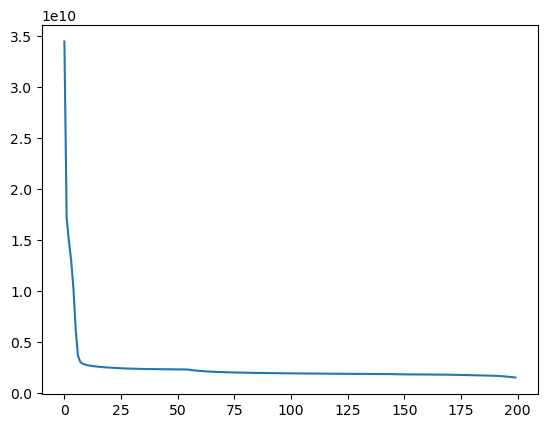

In [11]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()


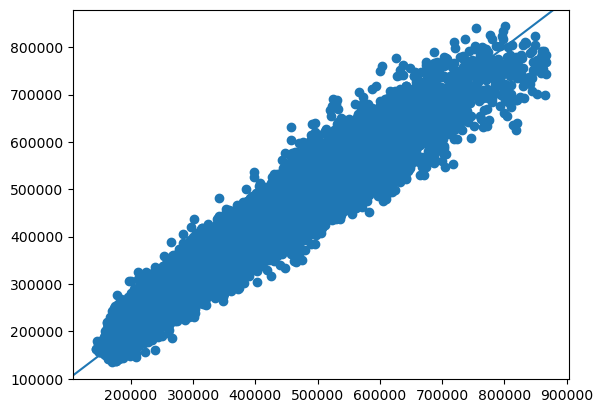

In [12]:
plt.scatter(y_test.cpu(), y_pred.detach().cpu())
plt.axline((2e5,2e5), slope=1)



In [15]:
df_pred = pd.Series(y_pred.detach().cpu().squeeze(), index=df_test.index).sort_index()
df_target = df_test.Household[df_pred.index]

In [16]:
climatology=df_train.Household.groupby(df_train.index.dayofyear).mean()
df_annual_cycle = pd.Series(df_train.index.dayofyear.map(climatology), index = df_train.index)
residual = df_annual_cycle-df_train.Household
hourly = residual.groupby(residual.index.hour).mean()
df_hourly_cycle = residual.index.hour.map(hourly)
df_cycles = pd.Series(df_test.index.dayofyear.map(climatology)+df_test.index.hour.map(hourly), index = df_test.index).loc[df_pred.index]


<Axes: >

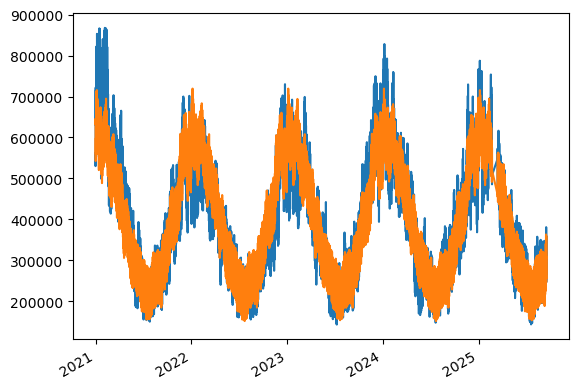

In [20]:
df_target.plot()
df_cycles.plot()

In [21]:
print(root_mean_squared_error(df_cycles, df_target))
print(root_mean_squared_error(y_test.cpu(), y_pred.detach().cpu()))

90880.81006885476
39538.3359375


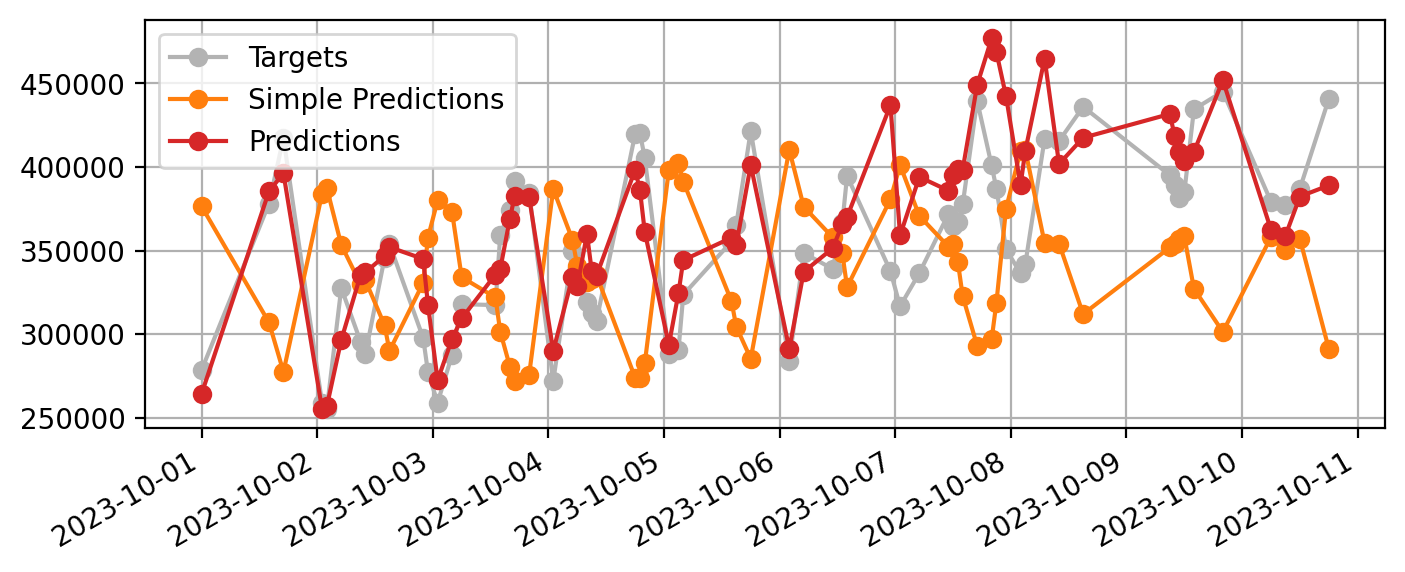

In [31]:
fig, ax = plt.subplots(figsize=(8,3), dpi=200)
df_target.loc['2023-10-01':'2023-10-10'].plot(label='Targets', color='.7', marker='o')
df_cycles.loc['2023-10-01':'2023-10-10'].plot(label='Simple Predictions', color='C1', marker='o')
df_pred.loc['2023-10-01':'2023-10-10'].plot( label='Predictions', color='C3', marker='o')
plt.legend()

plt.grid()
